In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta
os.getcwd()
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix



import shap
shap.initjs()

pd.set_option('display.max_columns', 30)

In [4]:
# read data

#stops_pre_covid = pd.read_parquet("~/Downloads/all_stops_ungrouped/stops_pre_covid.parquet")
#stops_during_covid = pd.read_parquet("~/Downloads/all_stops_ungrouped/stops_during_covid.parquet")
stops_post_covid = pd.read_parquet("~/Downloads/all_stops_ungrouped/rush_stops_post_covid.parquet")


df = stops_post_covid


# read in network characteristics
network_char = pd.read_csv("./data/network_char.csv")

# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_csv("~/Downloads/Studie P-treinen/Extract justifications.csv", sep = ";", encoding='latin-1')
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)

# count how many times a train was justified (by all / by P-train / by normal train)
trains_justifs_count = justifs.groupby(['REF_TOD_IMPACTED_TRAIN']).agg(all_justif_count=('REF_JUS_ID', 'count'),
                                                                       p_justif_count=('p_resp', 'sum')).reset_index()
trains_justifs_count['normal_justif_count'] = trains_justifs_count['all_justif_count'] - trains_justifs_count['p_justif_count']

# add justifications columns to punctuality dataframe
punct_justifs = all_punct.merge(trains_justifs_count, left_on = 'TRAIN_ID', right_on='REF_TOD_IMPACTED_TRAIN', how = "left")
punct_justifs = punct_justifs.drop(columns='REF_TOD_IMPACTED_TRAIN')
punct_justifs['all_justif_count'].fillna(0, inplace=True)
punct_justifs['p_justif_count'].fillna(0, inplace=True)
punct_justifs['normal_justif_count'].fillna(0, inplace=True)


Columns (28,30,34,35,37,38,39,40,41,42,43,50) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
stops_post_covid

,REF_TOD_TRAIN_ID,TRAIN_NUMBER,TRAIN_DEPARTURE_DATE,REF_PTCAR_NO,PTCAR_ORD_NO,THR_ARR,THR_DEP,HR_ARR,HR_DEP,EH_ARR,EH_DEP,COMMERCIAL_STOP_NATURE,DEPARTURE_REF_LINE_SECTION_NO,LINE,IDENTIFICATOR,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,p_indicator
0,30429876,13255,2022-06-05,810,101,1900-01-01 00:00:00,2022-06-05 06:56:00,1900-01-01 00:00:00,2022-06-05 06:58:32,0,152,1,1270,25.0,25,2022,6.0,Summer,1.0,1.0,6.0,5.0,2022-06-05,morning_rush,0
1,30430881,6067,2022-06-05,442,101,1900-01-01 00:00:00,2022-06-05 18:44:00,1900-01-01 00:00:00,2022-06-05 18:44:21,0,21,1,1258,166.0,166,2022,6.0,Summer,1.0,1.0,18.0,5.0,2022-06-05,evening_rush,0
2,30541622,3678,2022-06-23,215,123,2022-06-23 07:25:00,2022-06-23 07:26:00,2022-06-23 07:32:57,2022-06-23 07:34:18,477,498,2,1434,0.0,0/4,2022,6.0,Summer,0.0,0.0,6.0,23.0,2022-06-23,morning_rush,0
3,30430858,5286,2022-06-05,956,102,2022-06-05 16:13:00,2022-06-05 16:14:00,2022-06-05 16:11:42,2022-06-05 16:14:38,-77,38,2,993,37.0,37,2022,6.0,Summer,1.0,1.0,16.0,5.0,2022-06-05,evening_rush,0
4,30539760,7679,2022-06-23,418,106,2022-06-23 07:01:00,2022-06-23 07:01:00,2022-06-23 07:01:23,2022-06-23 07:01:46,23,46,2,1049,162.0,162,2022,6.0,Summer,0.0,0.0,6.0,23.0,2022-06-23,morning_rush,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603482,32033017,2066,2023-02-18,318,121,2023-02-18 17:39:00,2023-02-18 17:45:00,2023-02-18 17:40:29,2023-02-18 17:46:42,89,102,2,1622,50.0,50,2023,2.0,Winter,1.0,0.0,16.0,18.0,2023-02-18,evening_rush,0
4603483,32033239,1917,2023-02-18,221,118,2023-02-18 19:00:00,2023-02-18 19:04:00,2023-02-18 19:00:33,2023-02-18 19:04:23,33,23,2,1349,27.0,27,2023,2.0,Winter,1.0,0.0,18.0,18.0,2023-02-18,evening_rush,0
4603484,31637371,2206,2022-12-10,319,147,2022-12-10 08:21:00,2022-12-10 08:31:00,2022-12-10 08:20:33,2022-12-10 08:30:49,-26,-10,2,1326,57.0,57,2022,12.0,Winter,1.0,0.0,6.0,10.0,2022-12-10,morning_rush,0
4603485,31636558,4338,2022-12-10,840,106,2022-12-10 17:49:00,2022-12-10 17:58:00,2022-12-10 17:57:44,2022-12-10 18:03:24,524,324,2,1133,15.0,15,2022,12.0,Winter,1.0,0.0,17.0,10.0,2022-12-10,evening_rush,0


In [6]:
# add column to indicate if train suffered a small delay (>90 sec) at the stations
df['small_delay'] = df['EH_ARR'].apply(lambda x: 1 if x >= 90 else 0)

df

,REF_TOD_TRAIN_ID,TRAIN_NUMBER,TRAIN_DEPARTURE_DATE,REF_PTCAR_NO,PTCAR_ORD_NO,THR_ARR,THR_DEP,HR_ARR,HR_DEP,EH_ARR,EH_DEP,COMMERCIAL_STOP_NATURE,DEPARTURE_REF_LINE_SECTION_NO,LINE,IDENTIFICATOR,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,p_indicator,small_delay
0,30429876,13255,2022-06-05,810,101,1900-01-01 00:00:00,2022-06-05 06:56:00,1900-01-01 00:00:00,2022-06-05 06:58:32,0,152,1,1270,25.0,25,2022,6.0,Summer,1.0,1.0,6.0,5.0,2022-06-05,morning_rush,0,0
1,30430881,6067,2022-06-05,442,101,1900-01-01 00:00:00,2022-06-05 18:44:00,1900-01-01 00:00:00,2022-06-05 18:44:21,0,21,1,1258,166.0,166,2022,6.0,Summer,1.0,1.0,18.0,5.0,2022-06-05,evening_rush,0,0
2,30541622,3678,2022-06-23,215,123,2022-06-23 07:25:00,2022-06-23 07:26:00,2022-06-23 07:32:57,2022-06-23 07:34:18,477,498,2,1434,0.0,0/4,2022,6.0,Summer,0.0,0.0,6.0,23.0,2022-06-23,morning_rush,0,1
3,30430858,5286,2022-06-05,956,102,2022-06-05 16:13:00,2022-06-05 16:14:00,2022-06-05 16:11:42,2022-06-05 16:14:38,-77,38,2,993,37.0,37,2022,6.0,Summer,1.0,1.0,16.0,5.0,2022-06-05,evening_rush,0,0
4,30539760,7679,2022-06-23,418,106,2022-06-23 07:01:00,2022-06-23 07:01:00,2022-06-23 07:01:23,2022-06-23 07:01:46,23,46,2,1049,162.0,162,2022,6.0,Summer,0.0,0.0,6.0,23.0,2022-06-23,morning_rush,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603482,32033017,2066,2023-02-18,318,121,2023-02-18 17:39:00,2023-02-18 17:45:00,2023-02-18 17:40:29,2023-02-18 17:46:42,89,102,2,1622,50.0,50,2023,2.0,Winter,1.0,0.0,16.0,18.0,2023-02-18,evening_rush,0,0
4603483,32033239,1917,2023-02-18,221,118,2023-02-18 19:00:00,2023-02-18 19:04:00,2023-02-18 19:00:33,2023-02-18 19:04:23,33,23,2,1349,27.0,27,2023,2.0,Winter,1.0,0.0,18.0,18.0,2023-02-18,evening_rush,0,0
4603484,31637371,2206,2022-12-10,319,147,2022-12-10 08:21:00,2022-12-10 08:31:00,2022-12-10 08:20:33,2022-12-10 08:30:49,-26,-10,2,1326,57.0,57,2022,12.0,Winter,1.0,0.0,6.0,10.0,2022-12-10,morning_rush,0,0
4603485,31636558,4338,2022-12-10,840,106,2022-12-10 17:49:00,2022-12-10 17:58:00,2022-12-10 17:57:44,2022-12-10 18:03:24,524,324,2,1133,15.0,15,2022,12.0,Winter,1.0,0.0,17.0,10.0,2022-12-10,evening_rush,0,1


In [7]:

# get df of all train_id and lines combinations
lines_trains_df = df.groupby(['REF_TOD_TRAIN_ID', 'LINE']).agg(indic=("p_indicator", "max")).reset_index()

# group stops by train
df_intermediate = df.groupby(['REF_TOD_TRAIN_ID', 'YEAR_DEP', 'month', 'season', 'weekend', 'holiday',
                 'dep_hour_origin', 'day_origin', 'date_origin', 'rush', 'p_indicator']).agg(stations_count=("REF_PTCAR_NO", "size"),
                                                                                             small_delay_count=('small_delay', 'sum')).reset_index()
# make small_delay_proportion
df_intermediate['small_delay_prop'] = df_intermediate['small_delay_count'] / (df_intermediate['stations_count'] - 1)

# add targert column from all_punct
df_intermediate = df_intermediate.merge(punct_justifs[['TRAIN_ID', 'Retard_1pointage_valeur', 'NB', 'all_justif_count', 'p_justif_count', 'normal_justif_count']],
                                        left_on='REF_TOD_TRAIN_ID', right_on='TRAIN_ID', how = 'left')

# remove NA / dates past the all_punct cutoff (12th april 2023)
df_intermediate = df_intermediate[df_intermediate['TRAIN_ID'].notna()]

# check
df_intermediate

,REF_TOD_TRAIN_ID,YEAR_DEP,month,season,weekend,holiday,dep_hour_origin,day_origin,date_origin,rush,p_indicator,stations_count,small_delay_count,small_delay_prop,TRAIN_ID,Retard_1pointage_valeur,NB,all_justif_count,p_justif_count,normal_justif_count
0,30282279,2022,5.0,Spring,0.0,0.0,18.0,12.0,2022-05-12,evening_rush,0,13,4,0.333333,30282279.0,1.0,1.0,0.0,0.0,0.0
1,30282280,2022,5.0,Spring,0.0,0.0,7.0,12.0,2022-05-12,morning_rush,0,29,15,0.535714,30282280.0,1.0,2.0,0.0,0.0,0.0
2,30282281,2022,5.0,Spring,0.0,0.0,16.0,12.0,2022-05-12,evening_rush,0,16,6,0.400000,30282281.0,1.0,2.0,0.0,0.0,0.0
3,30282284,2022,5.0,Spring,0.0,0.0,7.0,12.0,2022-05-12,morning_rush,0,2,0,0.000000,30282284.0,1.0,1.0,0.0,0.0,0.0
4,30282285,2022,5.0,Spring,0.0,0.0,6.0,12.0,2022-05-12,morning_rush,0,2,1,1.000000,30282285.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382916,32345253,2023,4.0,Spring,0.0,0.0,7.0,12.0,2023-04-12,morning_rush,1,8,0,0.000000,32345253.0,1.0,1.0,0.0,0.0,0.0
382919,32345262,2023,4.0,Spring,0.0,0.0,7.0,12.0,2023-04-12,morning_rush,1,7,1,0.166667,32345262.0,1.0,1.0,0.0,0.0,0.0
382929,32345306,2023,4.0,Spring,0.0,0.0,7.0,12.0,2023-04-12,morning_rush,0,6,5,1.000000,32345306.0,0.0,1.0,0.0,0.0,0.0
382931,32345344,2023,4.0,Spring,0.0,0.0,7.0,12.0,2023-04-12,morning_rush,0,5,1,0.250000,32345344.0,1.0,1.0,0.0,0.0,0.0


In [8]:
df_intermediate['all_justif_count'].value_counts()

all_justif_count
0.0     312394
1.0      24489
2.0      11823
3.0       5859
4.0       3522
5.0       2121
6.0       1396
7.0        917
8.0        586
9.0        372
10.0       269
11.0       157
12.0       118
13.0        89
14.0        57
15.0        40
16.0        23
17.0        23
18.0        19
20.0         9
19.0         8
21.0         5
27.0         3
22.0         3
23.0         3
30.0         2
24.0         2
26.0         1
29.0         1
28.0         1
40.0         1
32.0         1
Name: count, dtype: int64

In [9]:

# merge with all lines OHE
df2 = lines_trains_df.merge(df_intermediate, on = 'REF_TOD_TRAIN_ID', how = 'left').drop(columns="indic")

# group by date_origin, rush, and line
df2 = df2.groupby(['date_origin', 'rush', 'LINE', 'YEAR_DEP', 'month', 'season',
                   'weekend', 'holiday', 'day_origin'])\
                    .agg(all_train_count=('REF_TOD_TRAIN_ID', 'size'),
                         p_train_count=('p_indicator', 'sum'),
                         on_time_count=('Retard_1pointage_valeur', 'sum'),
                         brussels_prop=('NB', lambda x: (x==2).mean()),
                         avg_stations_count=('stations_count', 'mean'),
                         all_justif_count_total=('all_justif_count', 'sum'),
                         p_justif_count_total=('p_justif_count', 'sum'),
                         normal_justif_count_total=('normal_justif_count', 'sum'),
                         stations_count_total=('stations_count', 'sum'),
                         small_delay_count_total=('small_delay_count','sum')).reset_index()

df2['normal_train_count'] = df2['all_train_count'] - df2['p_train_count']
df2['small_delay_prop_total'] = df2['small_delay_count_total'] / (df2['stations_count_total'] - df2['all_train_count']) 
df2['small_delay_prop_total'].fillna(0, inplace=True)

# make column for proportion of trains that is on time
df2['timely_prop'] = df2['on_time_count'] / df2['all_train_count']

# add target/label column based on service level required (we chose 90% as a placeholder)
df2['label'] = df2['timely_prop'].apply(lambda x: 0 if x < 0.9 else 1)

# make binary column to signal morning rush
df2['morning_rush'] = df2['rush'].apply(lambda x: 1 if x == 'morning_rush' else 0)
df2 = df2.drop(columns='rush') # drop original

# convert numeric categoricals to strings
df2['LINE'] = df2['LINE'].astype(str)
df2['YEAR_DEP'] = df2['YEAR_DEP'].astype(str)
df2['month'] = df2['month'].astype(str)

df2['morning_rush'] = df2['morning_rush'].astype(str)
df2['weekend'] = df2['weekend'].astype(str)
df2['holiday'] = df2['holiday'].astype(str)

df2['label'] = df2['label'].astype(str)

# add network characteristic variables
network_char['LINE'] = network_char['LINE'].astype(str)
df2 = df2.merge(network_char, on='LINE', how='left')

# check
print(df2[['label']].value_counts()) # mostly balanced classes
df2

label
0        21525
1        20565
Name: count, dtype: int64


,date_origin,LINE,YEAR_DEP,month,season,weekend,holiday,day_origin,all_train_count,p_train_count,on_time_count,brussels_prop,avg_stations_count,all_justif_count_total,p_justif_count_total,normal_justif_count_total,stations_count_total,small_delay_count_total,normal_train_count,small_delay_prop_total,timely_prop,label,morning_rush,Degree,Betweenness,Centrality,Pagerank
0,2022-05-12,0.0,2022.0,5.0,Spring,0.0,0.0,12.0,161,15.0,105.0,0.658385,16.198758,117.0,39.0,78.0,2608.0,1465.0,146.0,0.598692,0.652174,0,0,33,0.063468,0.492537,0.036023
1,2022-05-12,2.0,2022.0,5.0,Spring,0.0,0.0,12.0,9,2.0,7.0,0.777778,13.444444,18.0,6.0,12.0,121.0,65.0,7.0,0.580357,0.777778,0,0,9,0.002272,0.134328,0.011330
2,2022-05-12,4.0,2022.0,5.0,Spring,0.0,0.0,12.0,5,2.0,3.0,0.000000,5.600000,2.0,0.0,2.0,28.0,18.0,3.0,0.782609,0.600000,0,0,9,0.001957,0.134328,0.011150
3,2022-05-12,12.0,2022.0,5.0,Spring,0.0,0.0,12.0,14,0.0,8.0,0.357143,18.928571,1.0,1.0,0.0,265.0,136.0,14.0,0.541833,0.571429,0,0,12,0.007726,0.179104,0.014690
4,2022-05-12,13.0,2022.0,5.0,Spring,0.0,0.0,12.0,3,0.0,2.0,1.000000,17.000000,0.0,0.0,0.0,51.0,14.0,3.0,0.291667,0.666667,0,0,8,0.001149,0.119403,0.010413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42085,2023-04-12,161.0,2023.0,4.0,Spring,0.0,0.0,12.0,44,4.0,36.0,0.045455,11.272727,0.0,0.0,0.0,496.0,183.0,40.0,0.404867,0.818182,0,1,27,0.049772,0.402985,0.030410
42086,2023-04-12,162.0,2023.0,4.0,Spring,0.0,0.0,12.0,24,7.0,22.0,0.000000,8.666667,0.0,0.0,0.0,208.0,63.0,17.0,0.342391,0.916667,1,1,17,0.031773,0.253731,0.021129
42087,2023-04-12,165.0,2023.0,4.0,Spring,0.0,0.0,12.0,7,3.0,7.0,0.000000,9.714286,0.0,0.0,0.0,68.0,6.0,4.0,0.098361,1.000000,1,1,4,0.001807,0.059701,0.007295
42088,2023-04-12,166.0,2023.0,4.0,Spring,0.0,0.0,12.0,2,0.0,2.0,0.000000,16.000000,0.0,0.0,0.0,32.0,2.0,2.0,0.066667,1.000000,1,1,3,0.000588,0.044776,0.005822


In [10]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df2.describe())

                         date_origin  day_origin  all_train_count   
count                          42090       42090            42090  \
mean   2022-10-26 11:48:46.699928832          16               24   
min              2022-05-12 00:00:00           1                1   
25%              2022-08-03 00:00:00           8                6   
50%              2022-10-27 00:00:00          16               13   
75%              2023-01-18 00:00:00          23               30   
max              2023-04-12 00:00:00          31              184   
std                              NaN           9               29   

       p_train_count  on_time_count  brussels_prop  avg_stations_count   
count          42090          42090          42090               42090  \
mean               3             20              0                  13   
min                0              0              0                   1   
25%                0              6              0                  10   
50%     

In [11]:
# Split the data into training and testing sets
X = df2.drop(columns=['label', 'date_origin', 'day_origin', 'all_train_count', 'on_time_count',
                      'all_justif_count_total', 'stations_count_total', 'small_delay_count_total', 'timely_prop'], axis=1)
y = df2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)



# define the numeric features
cat_cols = ['LINE', 'season', 'YEAR_DEP', 'month']
binary_features = ['morning_rush', 'weekend', 'holiday']
numeric_features = ['p_train_count', 'normal_train_count',  'avg_stations_count', 'p_justif_count_total', 'normal_justif_count_total', 'Degree']
numeric_features_already_scaled = ['brussels_prop', 'small_delay_prop_total']

# initialize the scaler
scaler = StandardScaler()

# fit scaler on all the numeric variables
scaler.fit(X_train[numeric_features])

# scale features
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# check
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(X_train[numeric_features].describe())






       p_train_count  normal_train_count  avg_stations_count   
count       29463.00            29463.00            29463.00  \
mean            0.00                0.00               -0.00   
std             1.00                1.00                1.00   
min            -0.64               -0.80               -3.04   
25%            -0.64               -0.58               -0.63   
50%            -0.39               -0.35                0.01   
75%             0.35                0.21                0.59   
max             6.32                5.23                4.25   

       p_justif_count_total  normal_justif_count_total   Degree  
count              29463.00                   29463.00 29463.00  
mean                   0.00                       0.00    -0.00  
std                    1.00                       1.00     1.00  
min                   -0.42                      -0.41    -1.40  
25%                   -0.42                      -0.41    -0.73  
50%                   -0.42

In [12]:
# create dummy variables for categorical features (such as last_family_indep)
X_train_dummies = pd.get_dummies(X_train[cat_cols])
X_train_dummies = X_train_dummies.astype(int) # binary for shap

X_test_dummies = pd.get_dummies(X_test[cat_cols])
X_test_dummies = X_test_dummies.astype(int) # binary for shap

X_test_dummies = X_test_dummies.reindex(columns = X_train_dummies.columns, fill_value=0)

# add dummies to train/test, remove original columns
X_train = X_train.drop(columns=cat_cols).drop(columns='small_delay_prop_total')
X_train = pd.concat([X_train, X_train_dummies], axis=1)

X_test = X_test.drop(columns=cat_cols).drop(columns='small_delay_prop_total')
X_test = pd.concat([X_test, X_test_dummies], axis=1)

# check
X_train

,weekend,holiday,p_train_count,brussels_prop,avg_stations_count,p_justif_count_total,normal_justif_count_total,normal_train_count,morning_rush,Degree,Betweenness,Centrality,Pagerank,LINE_0.0,LINE_10.0,...,season_Winter,YEAR_DEP_2022.0,YEAR_DEP_2023.0,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0
29349,1.0,1.0,-0.642804,0.000000,1.010228,-0.423167,-0.412200,-0.576253,0,-0.181759,0.002069,0.164179,0.013344,0,0,...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
8578,0.0,0.0,0.850136,0.000000,-2.276683,0.109284,0.120670,-0.799722,0,-0.844337,0.000132,0.074627,0.007496,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
25014,0.0,0.0,-0.393981,0.000000,-0.759647,-0.423167,-0.412200,-0.687987,0,-0.954766,0.000041,0.059701,0.006694,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
37289,1.0,0.0,-0.642804,0.000000,-2.529522,-0.423167,-0.412200,-0.501763,1,-0.844337,0.001299,0.074627,0.008144,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
34276,0.0,0.0,-0.642804,0.000000,0.323949,-0.423167,-0.412200,-0.539008,0,-0.402618,0.003274,0.134328,0.011638,0,0,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0.0,0.0,0.103666,0.000000,-0.456240,-0.423167,-0.145765,-0.352783,1,-0.954766,0.001807,0.059701,0.007295,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
15377,0.0,0.0,1.098959,0.421053,0.522292,0.854716,0.653541,1.062523,0,1.364255,0.033790,0.373134,0.027780,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
17730,0.0,0.0,0.352489,0.193548,0.039651,0.535245,-0.145765,0.205891,1,2.137262,0.098940,0.477612,0.036517,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
28030,0.0,0.0,0.352489,0.102041,-0.677088,-0.103696,-0.056953,0.876299,0,-0.071330,0.004122,0.179104,0.014586,0,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
# label encode the label

# initialise
lab_encoder = LabelEncoder()

# fit on training data
lab_encoder.fit(y_train)


# transform train and test
y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

# check
y_test

array([1, 1, 1, ..., 0, 1, 1])

In [14]:
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=123)

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

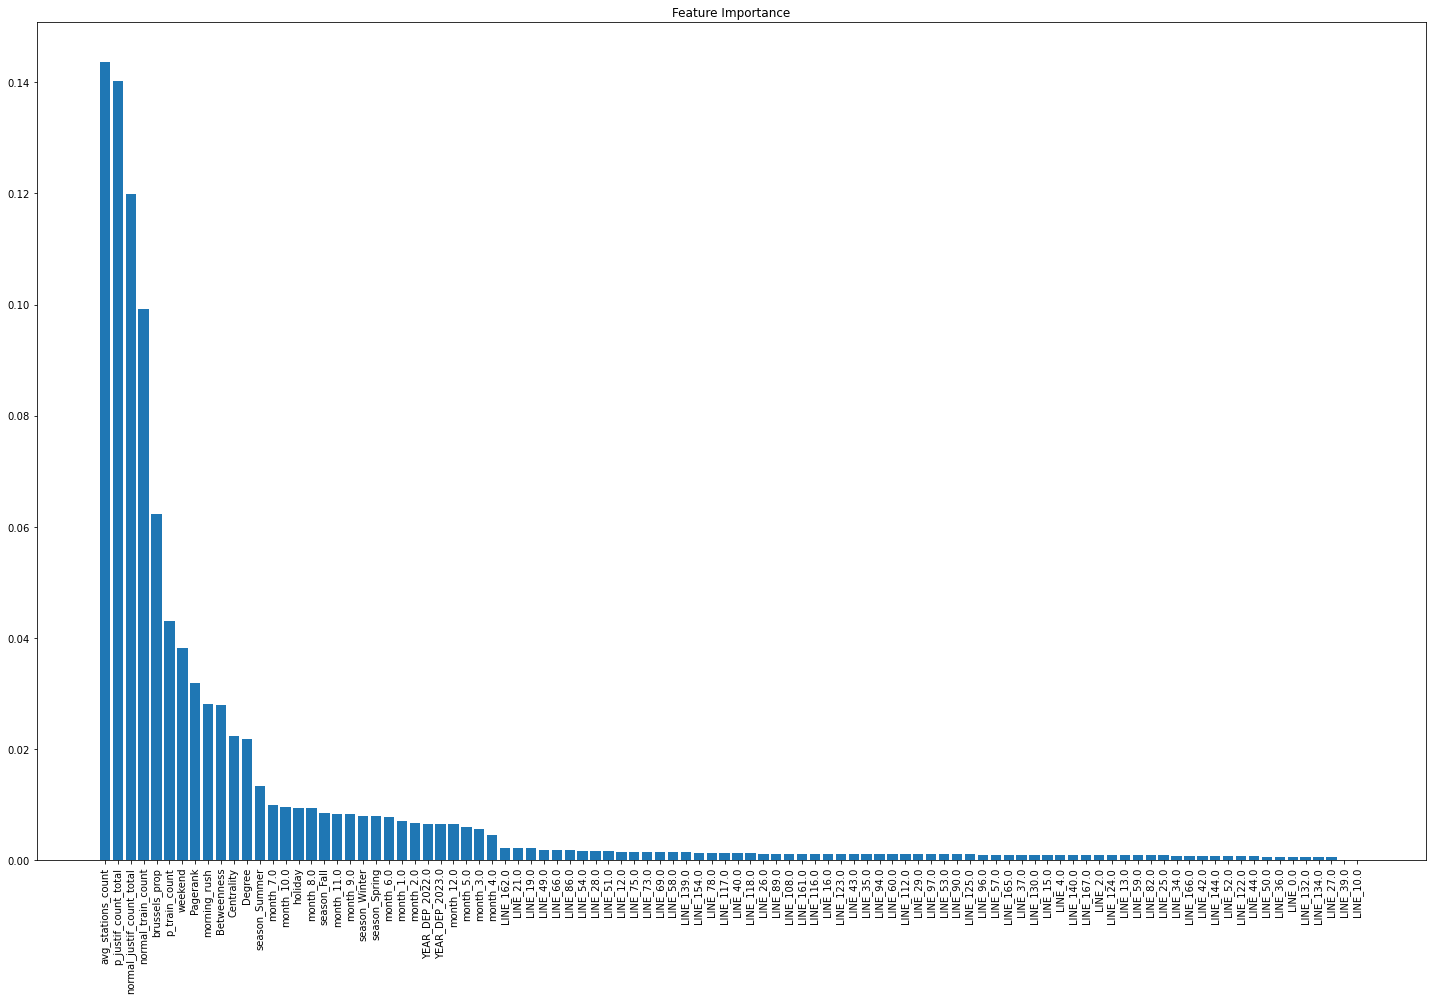

In [15]:
# Feature importances:

importances = rfc.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
 
fig, ax = plt.subplots(figsize=(20, 14)) 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Predict the labels of the testing data
y_pred = rfc.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.7194899817850637
Precision: 0.7065868263473054
Recall: 0.72744970798183
F1 score: 0.7168665067945643


In [17]:
# Predict the class probabilities for the testing data
y_pred_proba = rfc.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print('AUC score:', auc_score)

AUC score: 0.7894536418205643


In [18]:
# Create an explainer object for the random forest classifier
explainer = shap.TreeExplainer(rfc)

# Calculate the SHAP values for a single instance
shap_values = explainer.shap_values(X_test[:50])

# Print the SHAP values and corresponding feature names
print('SHAP values:', shap_values)
print('Feature names:', X_test.columns)

SHAP values: [array([[-0.0748241 ,  0.00232755, -0.01764296, ...,  0.00298139,
         0.00281129,  0.00101283],
       [-0.07010212,  0.00569211, -0.00655516, ...,  0.00666074,
         0.02741097,  0.00241408],
       [ 0.0314017 ,  0.00559844,  0.02861587, ...,  0.01184425,
         0.01433705,  0.00372522],
       ...,
       [ 0.0255529 ,  0.00319225,  0.02578744, ...,  0.00882082,
         0.0059344 , -0.00692142],
       [-0.10207952,  0.00329976, -0.02477657, ...,  0.00252527,
         0.00355657, -0.01446219],
       [ 0.03953366,  0.00269633,  0.04070416, ...,  0.00451355,
         0.00586856,  0.00512312]]), array([[ 0.0748241 , -0.00232755,  0.01764296, ..., -0.00298139,
        -0.00281129, -0.00101283],
       [ 0.07010212, -0.00569211,  0.00655516, ..., -0.00666074,
        -0.02741097, -0.00241408],
       [-0.0314017 , -0.00559844, -0.02861587, ..., -0.01184425,
        -0.01433705, -0.00372522],
       ...,
       [-0.0255529 , -0.00319225, -0.02578744, ..., -0.00882

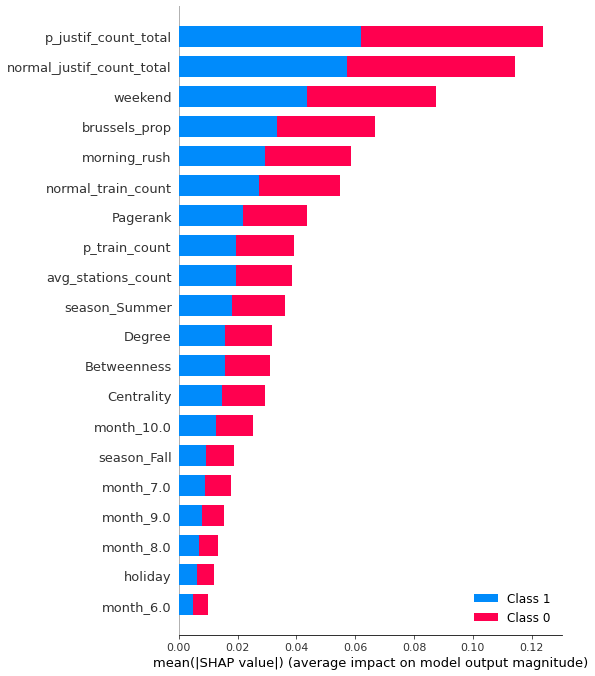

<Figure size 432x288 with 0 Axes>

In [19]:
# get summary plot
shap.summary_plot(shap_values, X_test)
plt.tight_layout()

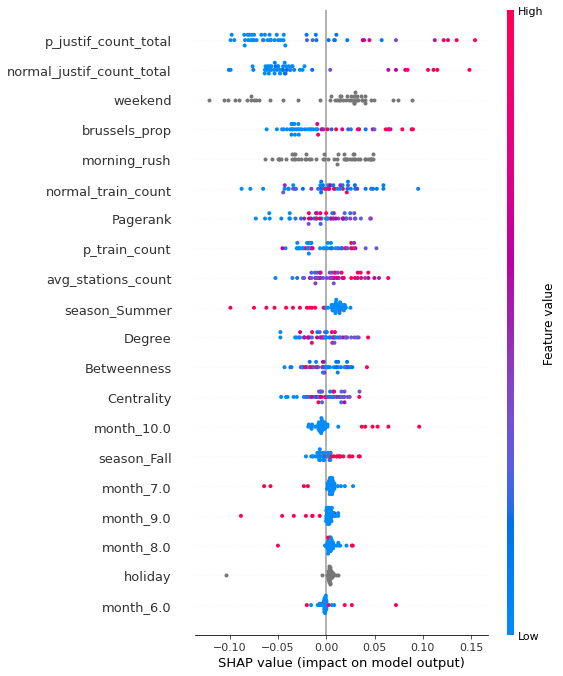

In [20]:
shap_values = explainer.shap_values(X_test[:50])
fig, ax = plt.subplots(figsize=(18, 12))
shap.summary_plot(shap_values[0], X_test[:50], plot_type='dot', max_display=20)
# show the plot
plt.show()

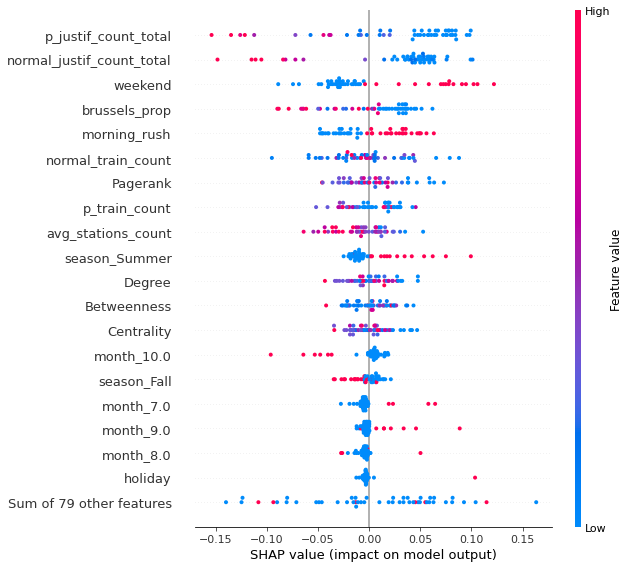

In [21]:
# Create an explainer object for the random forest classifier
explainer = shap.TreeExplainer(rfc)

# Calculate the SHAP values 
explainer = shap.TreeExplainer(rfc)
shap_values1 = explainer(X_test[:50])
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

# Create a beeswarm plot of the SHAP values
fig, ax = plt.subplots(figsize=(18, 12))
shap.plots.beeswarm(shap_values2, max_display=20)


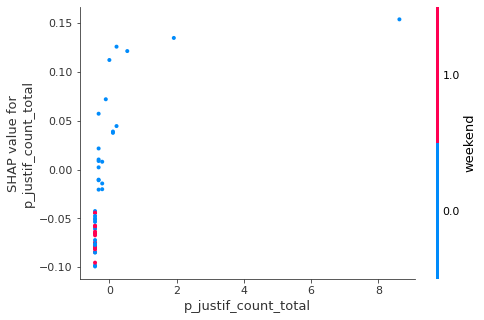

In [22]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap_values = explainer.shap_values(X_test[:50])
shap.dependence_plot('p_justif_count_total', shap_values[0], X_test[:50],interaction_index='weekend')

In [23]:
print(rfc.classes_[0])

0


In [24]:
shap.partial_dependence_plot("p_justif_count_total", rfc.predict, 
                             X_test[:50], ice=False)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
X_test[:50]

,weekend,holiday,p_train_count,brussels_prop,avg_stations_count,p_justif_count_total,normal_justif_count_total,normal_train_count,morning_rush,Degree,Betweenness,Centrality,Pagerank,LINE_0.0,LINE_10.0,...,season_Winter,YEAR_DEP_2022.0,YEAR_DEP_2023.0,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0
3893,1.0,0.0,-0.642804,0.000000,-0.759647,-0.423167,-0.412200,-0.650742,0,-1.065196,0.001053,0.044776,0.006528,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
11709,1.0,0.0,-0.642804,1.000000,0.504549,-0.423167,-0.412200,-0.576253,0,-0.733907,0.000248,0.089552,0.008133,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3388,0.0,0.0,0.103666,0.000000,-0.351842,-0.423167,-0.234577,0.243135,0,-0.071330,0.010616,0.179104,0.014986,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
35788,0.0,0.0,0.103666,0.131579,-0.786262,0.535245,0.120670,0.503850,0,0.370389,0.006560,0.238806,0.018086,0,0,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
20511,1.0,0.0,-0.642804,0.000000,-0.759647,-0.423167,-0.412200,-0.687987,1,-0.181759,0.002069,0.164179,0.013344,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
30835,0.0,0.0,-0.393981,0.000000,0.721268,-0.423167,-0.412200,-0.576253,1,-1.065196,0.000588,0.044776,0.005822,0,0,...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
21493,1.0,0.0,-0.642804,0.500000,0.335989,-0.423167,-0.412200,-0.352783,1,0.480818,0.009792,0.253731,0.019206,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
40183,0.0,0.0,0.850136,0.000000,-1.771005,-0.423167,-0.234577,-0.799722,0,-1.396485,0.000000,0.000000,0.002234,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
16321,0.0,0.0,0.352489,0.500000,-0.290089,0.109284,0.564729,-0.427273,1,0.259959,0.005794,0.223881,0.017202,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
5832,0.0,0.0,-0.642804,0.000000,1.768745,-0.316677,-0.412200,-0.687987,1,-0.402618,0.003274,0.134328,0.011638,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
idx = 15
exp = shap.Explanation(shap_values2, shap_values2, shap_values2, feature_names=X_test.columns)
shap.plots.waterfall(exp[idx], max_display=20)

In [ ]:
shap.summary_plot(shap_values2)